In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime

In [2]:
from src.data.make_dataset import make_dataset
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.data.image_loaders import VehiculesFixedImageLoader
from src.features.pipelines import RawImageToFeatures
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.detectors import SliderDetector
from src.data.sliders import SlidingWindow

In [3]:
BND_BOX_SIZE = (256, 256)
SLIDER_STEP_SIZE = 32
DATASET_PATH = '../../data/interim/vehicules/'
WORKERS = 7

### Vehicules Dataset

In [4]:
vehiculesFixedImageLoader = VehiculesFixedImageLoader(bnd_box_size=BND_BOX_SIZE)

image = vehiculesFixedImageLoader.load_image(
    '../../data/raw/vehicules/Vehicules1024/00000001_co.png',
    '../../data/raw/vehicules/Annotations1024/00000001.txt'
)

In [ ]:
plt.imshow(image.image)
plt.show()

In [ ]:
plt.imshow(image.get_car(image.bnd_boxes[0]))

### Loading dataset

In [29]:
dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)


images = dataset_loader.load_dataset(
    input_folder_filepath=DATASET_PATH,
    images_files_types=('png',),
    annotations_files_types=('txt',),
    verbose=True
)

100%|██████████| 66/66 [00:02<00:00, 25.10it/s]


In [ ]:
plt.imshow(images[0].get_car(images[0].bnd_boxes[0]))
plt.show()

In [5]:
process_pipeline=RawImageToFeatures(
        processors=[],
        descriptors=[
            HOGDescriptor(
                orientations = 9,
                cells_per_block = (2, 2),
                pixels_per_cell = (8, 8),
                multichannel = True,
                visualize = True
            ),
            LBPDescriptor(
                bins = 256,
                range = (0, 256)
            )
        ]
    )

In [27]:
start_time = time.time()

data = make_dataset(
    input_folder_filepath=DATASET_PATH,
    output_filepath='output_path',
    dataset_loader=dataset_loader,
    images_files_types=('png',),
    annotations_files_types=('txt',),
    process_pipeline=process_pipeline,
    negative_images_size=BND_BOX_SIZE,
    negative_examples_size=0.3,
    workers=WORKERS,
    verbose=True
)

print()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 242/242 [00:00<00:00, 510.56it/s]



--- 131.99051141738892 seconds ---


In [28]:
X = list(map(lambda x: x[1], data))
y = list(map(lambda x: x[2], data))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.91      0.82        81
           1       0.56      0.26      0.36        34

    accuracy                           0.72       115
   macro avg       0.65      0.59      0.59       115
weighted avg       0.69      0.72      0.69       115



### Sliding detection

In [16]:
sliding_window = SlidingWindow(
    step_size=SLIDER_STEP_SIZE,
    window_size=BND_BOX_SIZE
)

In [17]:
class ModelWrapper:

    def __init__(self, model):
        self.model = model

    def predict(self, x):
        return self.model.predict(x.reshape(1, -1))

In [18]:
slider_detector = SliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ModelWrapper(clf)
)

### Parallel approach

In [30]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(deepcopy(images[31]), 0, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))

1024it [20:20,  1.19s/it]



--- 1220.5481197834015 seconds ---


In [31]:
len(bnd_boxes)

0

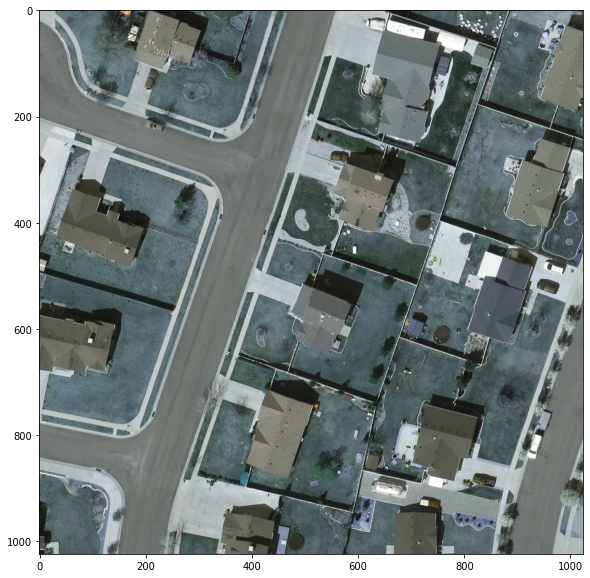

In [32]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.savefig('./detection-'+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'.jpg')